<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Image/Soma_Size/Cell_pose_AR_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install matplotlib --quiet

In [3]:

import tifffile
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage


In [4]:
source_directory = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/'


my_tiffs = list()
for rt,dirs,file_list in os.walk(source_directory):
    for file in file_list:
        if 'tif' in file:
            my_tiffs.append(os.path.join(rt,file))
print(my_tiffs)

curr_tif = my_tiffs[0]

['C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/CA3_a.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/CA3_RGBW_.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/CA3_RGB_Color.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/DG_a.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-22-22__S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-24-22_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/MDGA2_08-24-22__S001_DG_40X_2XZoom_1.tif', 'C:/Users/dennis.t

In [5]:
curr_tif = 'C:/Users/dennis.tabuena/Dropbox (Gladstone)/0_Projects/_Hyper+Crisper/NeunSoma/CA3_RGBW_.tif'

In [6]:
def dimension_to_front(data,dim_x):
    dim_list = list(np.arange(len(data.shape)))
    transpose = [dim_list[dim_x]] + dim_list[:dim_x] + dim_list[dim_x+1:]
    data_t = data.transpose(transpose)
    data_t =data_t.astype('float16')
    invs_transpose = list(np.argsort(transpose))
    return data_t, transpose, invs_transpose

def norm_channels(im_data,tiff_format,clip=False):
    color_dim = tiff_format.index('c')
    data_t, transpose, invs_transpose = dimension_to_front(im_data,color_dim)
    num_channels = data_t.shape[0]
    for c in np.arange(num_channels):
        c_data = data_t[c,:]
        (top,bot) = np.percentile(c_data.flatten(),[99,1])
        c_data = (c_data-bot)/(top-bot)
        data_t[c,:] = c_data
    im_data = data_t.transpose(invs_transpose)
    if clip:
        im_data[im_data>1]=1
        im_data[im_data<0]=0
    return im_data

def med_filt_stack(img,d):
    color_dim = tiff_format.index('c')
    z_dim = tiff_format.index('z')
    color_dim=1
    z_dim=0
    for c in range(img.shape[color_dim]):
        for z in range(img.shape[z_dim]):
            img[z,c,:,:] = skimage.filters.median(img[z,c,:,:],footprint=np.ones([d,d]))
    return img



(44, 3, 800, 800)


[]

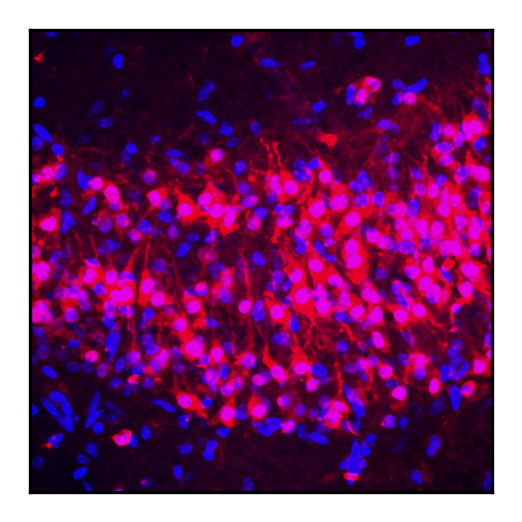

In [9]:
# tiff_data_raw = tifffile.imread(curr_tif)
# tiff_format = 'zcyx'

tiff_data = med_filt_stack(tiff_data_raw,6)
tiff_data = norm_channels(tiff_data,'zcyx',clip=True)
tiff_data = tiff_data[:,[3,0,2],:,:]
print(tiff_data.shape)
tiff_data[:,1,:,:]=0

max_proj_rgb = np.max(tiff_data,axis=0).transpose(1,2,0) *225
fig,ax=plt.subplots(1,1,figsize=(2,2),dpi=300)
ax.imshow(max_proj_rgb.astype('uint8'))
ax.set_xticks([])
ax.set_yticks([])

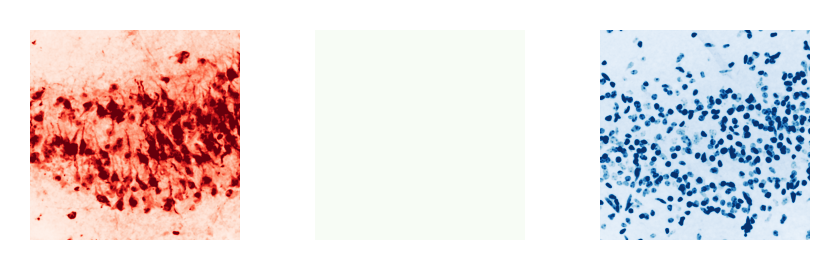

In [10]:
""" Display Split Projections """
num_c = tiff_data.shape[1]
fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
colors = ['Reds','Greens','Blues','gray']
for c in range(num_c):
    ax[c].imshow(np.max(tiff_data[:,c,:,:],axis=0), cmap=colors[c],vmin=0,vmax=1)
    ax[c].axis('off')
plt.tight_layout()

In [9]:
# colors = ['Reds','Greens','Blues','gray_r']
# for z in range(tiff_data.shape[0]):
#     num_c = tiff_data.shape[1]
#     fig,ax=plt.subplots(1,num_c,figsize=(num_c*1,1),dpi=300)
#     for c in range(num_c):
#         ax[c].imshow(tiff_data[z,c], cmap=colors[c],vmin=0,vmax=1)
#         ax[c].axis('off')
#     plt.tight_layout()
#     plt.show()

In [11]:
!pip install cellpose --quiet
from cellpose import models

In [12]:
print(tiff_data.shape)
cell_channel = 1
nuclear_channel = 3
channel_axis = 1
print('nuclear_channel',nuclear_channel)
print('cell_channel',cell_channel)
model = models.Cellpose(model_type='cyto')


(44, 3, 800, 800)
nuclear_channel 3
cell_channel 1


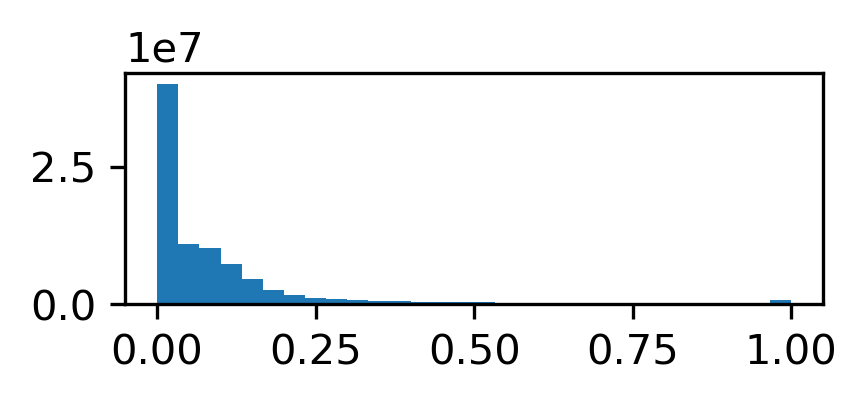

In [15]:
fig,ax=plt.subplots(1,figsize=(3,1),dpi=300)
_ = plt.hist(tiff_data.flatten(),30)

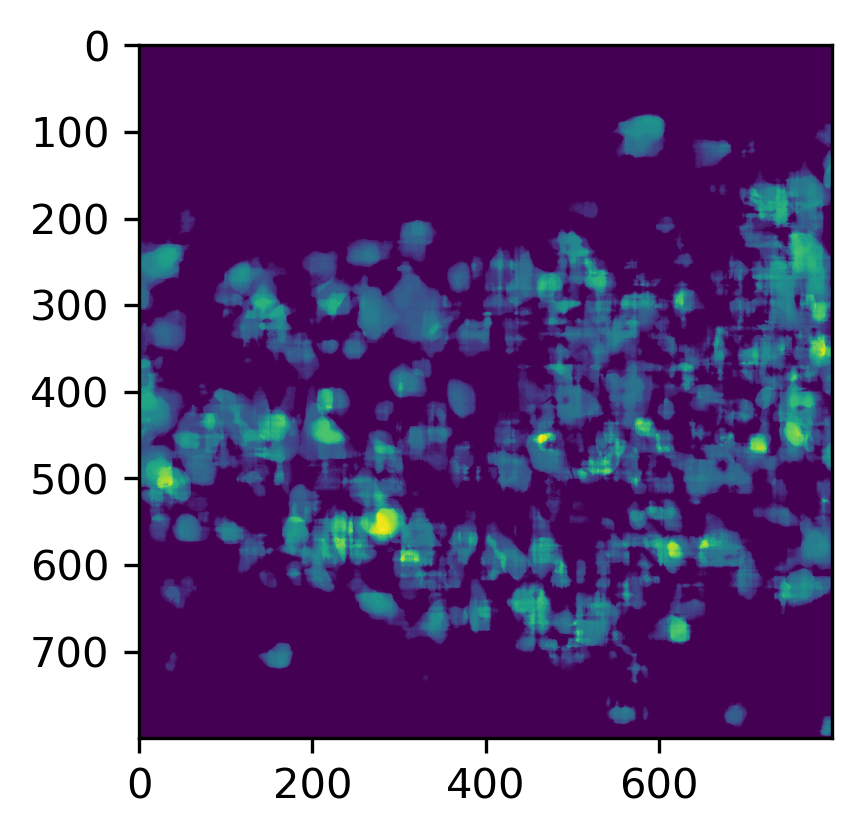

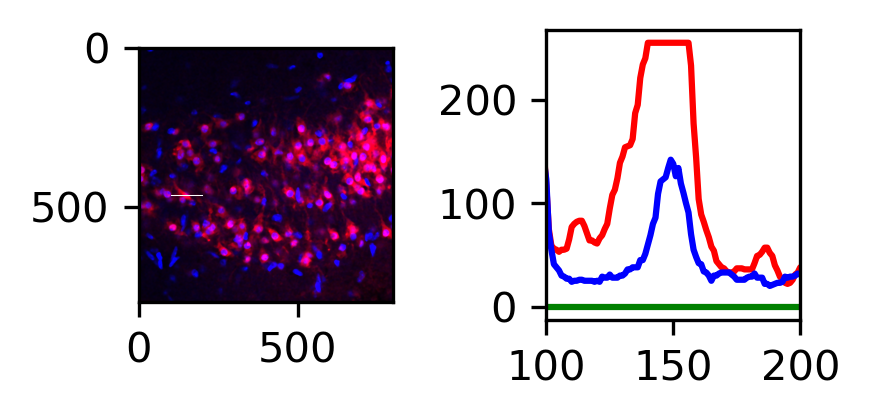

In [18]:
img_rgb = tiff_data.transpose([0,2,3,1])*255
img_rgb[img_rgb>255]=255
img_rgb[img_rgb<0]=0
img_rgb=img_rgb.astype('uint8')
fig,ax =plt.subplots(1,2,figsize=(3,1.5),dpi=300)
ax[0].imshow(img_rgb[27])
y=465
xb=[100,200]
ax[0].plot(xb,[y,y],'w',linewidth=.25)
ax[1].plot(img_rgb[27,y,:,0],color='r')
ax[1].plot(img_rgb[27,y,:,1],color='g')
ax[1].plot(img_rgb[27,y,:,2],color='b')
ax[1].set_xlim(xb)
plt.tight_layout()

In [21]:
zi = 35
(zi_masks, zi_flows, zi_styles, zi_diams) =  model.eval(tiff_data[zi,:,:,:], channels=[cell_channel, nuclear_channel], channel_axis = 2, diameter=40.0, do_3D=True) #
fig,ax=plt.subplots(1,figsize=(1.5,1.5),dpi=300)
plt.imshow(np.sum(masks>0,axis=0))

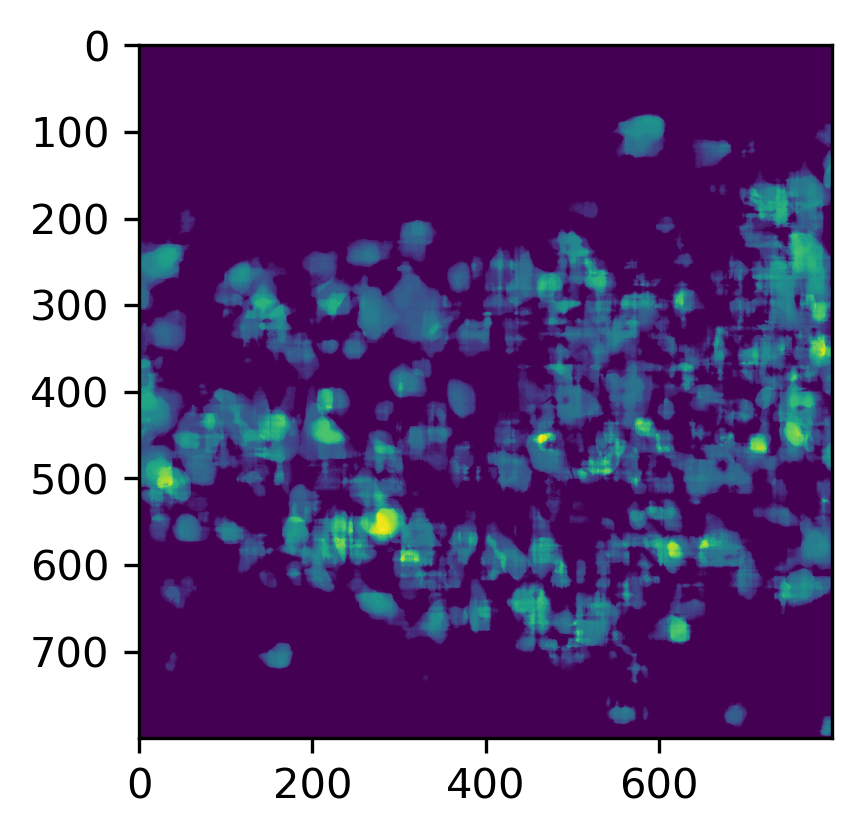

In [20]:
(masks, flows, styles, diams) =  model.eval(tiff_data, channels=[cell_channel, nuclear_channel], channel_axis = 1, diameter=40.0, do_3D=True) #
fig,ax=plt.subplots(1,figsize=(1.5,1.5),dpi=300)
plt.imshow(np.sum(masks>0,axis=0))

In [19]:
vmax=np.nanmax(masks)
levels = np.arange(vmax+1).astype(int)
print(levels)

NameError: name 'masks' is not defined

In [1]:
# masks=masks.astype(float)
# masks[masks<1]=np.nan

top = np.nanmax(masks)
masks.shape
num_z = tiff_data.shape[0]
for z in range(num_z):
    fig,ax=plt.subplots(1,2,figsize=(6,2),dpi=300)
    ax[0].imshow(tiff_data[z,cell_channel-1,:,:], cmap='Reds',vmin=0,vmax=1)
    ax[1].imshow(tiff_data[z,nuclear_channel-1,:,:], cmap='Blues',vmin=0,vmax=1)
    # ax[2].imshow(img_rgb[z,:,:])
    # ax[0].contour(masks[z,:,:],linewidths=.2,vmin=0,vmax=vmax,cmap='prism',levels=levels)
    ax[1].contour(masks[z,:,:],linewidths=.2,vmin=0,vmax=vmax,cmap='prism',levels=levels)
    ax[2].contour(masks[z,:,:],linewidths=.2,vmin=0,vmax=vmax,cmap='prism',levels=levels)
    plt.tight_layout


NameError: name 'np' is not defined

In [ ]:
# tiff_data_list = [tiff_data[z,:,:,:] for z in range(tiff_data.shape[0])]

In [ ]:
voxels = [0.2652, 0.2652, 0.6]

In [ ]:
non_zero = masks[~np.isnan(masks)]
num_cells = np.max(non_zero).astype(int)
print(num_cells)
edges = np.arange(0,num_cells)
pxl_counts, ids = np.histogram(masks[~np.isnan(masks)],bins = edges)

size_counts, sizes = np.histogram(np.log10(pxl_counts+1),bins=200)

fig,ax = plt.subplots(1,1,figsize=(2,1),dpi=300)
ax.stairs(size_counts,sizes) #np.cumsum(size_counts)
ax.set_yscale('log')